#Final Project: Evaluating Written Math Expressions With CNNs

*Nathan Kampbell, Nicole Miller*

For our project, we wanted to build an app that took in a variety of handwritten mathematical expressions and returned their solutions. This involved several steps, namely Data Manipulation, developing Grid Search and Image Processing, Experimentation, and Evaluating our results. These steps can be found in the sections below, along with a more detailed description of each step.

These steps were completed individually as per the original project proposal with input from both group members. However, we ended up focusing less on completing each portion individually and more on working as a team to work through each step. We met up once or twice a week and talked through the problems we needed to solve.

As a whole, we found the ultimate application was able to solve a variety of problems. We used the dataset listed in our project proposal, (HASYv2), which gave us access to a large variety of symbols to train the CNN on. However, this also limited our equations to basic algebraic functions such as addition, multiplication, division, subtraction, and comparisons.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import torch
from itertools import permutations

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


##Data Manipulation

###Preprocess HASYv2 to be compatible with the CNN given in class

The dataset we chose to work with is the [HASYv2](https://www.kaggle.com/guru001/hasyv2) dataset, [1]. It contains a variety of numbers, letters, and mathematical symbols, which we believed would allow us train a model for the recognition of several different kinds of equations.

![](https://drive.google.com/uc?export=view&id=1HgJrRd0el789e63f0Jelf-It6c-YhVd6)

Preprocessing the images in HASYv2 turned out to be an easier step than expected. Using matplotlib, the dataset's images could be read into (n, 32, 32, 3) numpy arrays. Each of the color channels were identical, as the images themselves are grayscale, and so a single call to reshape got the data into the right shape, (n, 1, 32, 32).

###Form a usable subset of HASYv2

With the images pre-processed, we then formed a subset of HASYv2 for our purposes. This was saved to a file "hasyv2_subset.npz", available [here](https://drive.google.com/uc?id=1cDVFAAmXDDCUX9ExuripCfx_83Ykf0ZT) or by running the following code cell (requires [gdown](https://github.com/wkentaro/gdown)).

In [ ]:
!gdown 1cDVFAAmXDDCUX9ExuripCfx_83Ykf0ZT

Downloading...
From: https://drive.google.com/uc?id=1cDVFAAmXDDCUX9ExuripCfx_83Ykf0ZT
To: /content/hasyv2_subset.npz
100% 75.2M/75.2M [00:00<00:00, 296MB/s]


Several choices had to be made in order to create this subset. For example, the dataset did not contain the equal sign "=". As such, we had to substitute in a similar symbol, "≡". A list of the 32 symbols we chose to use and their code translations can be found below.

In [ ]:
data = np.load('hasyv2_subset.npz')
images = data['images']
labels = data['labels']
unicode_map = data['unicode']
python_map = data['python']

classes = np.unique(labels)

n_total = images.shape[0]
n_train = int(0.8*n_total)
randomIndices = np.arange(n_total)
np.random.shuffle(randomIndices)
Xtrain, Xtest = images[randomIndices[:n_train]], images[randomIndices[n_train:]]
Ttrain, Ttest = labels[randomIndices[:n_train]], labels[randomIndices[n_train:]]

num_total = np.sum(labels == classes, axis=0)
num_train = np.sum(Ttrain == classes, axis=0)
num_test = np.sum(Ttest == classes, axis=0)

print('images.shape:', images.shape)
print('labels.shape:', labels.shape)
print('X[train,test].shape:', Xtrain.shape, Xtest.shape)
print('T[train,test].shape:', Ttrain.shape, Ttest.shape)
pd.DataFrame(
    columns = ['Symbol', 'Code', 'Train Count', 'Test Count', 'Total Count'],
    data = np.vstack((unicode_map, python_map, num_train, num_test, num_total)).T
  )

images.shape: (18337, 1, 32, 32)
labels.shape: (18337, 1)
X[train,test].shape: (14669, 1, 32, 32) (3668, 1, 32, 32)
T[train,test].shape: (14669, 1) (3668, 1)


,Symbol,Code,Train Count,Test Count,Total Count
0,0,0,98,35,133
1,1,1,101,17,118
2,2,2,106,18,124
3,3,3,96,24,120
4,4,4,50,11,61
5,5,5,62,16,78
6,6,6,84,16,100
7,7,7,61,14,75
8,8,8,97,24,121
9,9,9,72,18,90


## Grid Search and Image Processing

###Perform a grid search for network hyperparameters using k-fold cross validation

In order to find a good set of hyperparameters for our CNN, we decided to use k-fold cross validation. We lifted the code for this from assignment 3 and modified it for use with any type of neural network.

In [ ]:
# Copied from assignment 3
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [ ]:
def accuracy(Y, T):
  return np.mean(Y == T)

# Copied from assignment 3, without parameter search
def run_k_fold_cross_validation(X, T, n_folds, Network, n_in, n_out,
                                init_params, train_params):
  acc_results = []
  n_sets = n_folds * (n_folds-1)
  i = 1

  for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
    print(f'\r{n_folds}-fold cross validation: ['+ '='*i + ' '*(n_sets-i) + ']',
          end='')
    i += 1

    net = Network(n_inputs=n_in, n_outputs=n_out, **init_params, device=device)
    net.train(Xtrain, Ttrain, **train_params, verbose=False)

    acc_results.append([
        accuracy(net.use(Xtrain)[0], Ttrain),
        accuracy(net.use(Xval)[0], Tval),
        accuracy(net.use(Xtest)[0], Ttest)
    ])

  print()
  return np.mean(acc_results, axis=0)

We then defined a grid search function which makes use of k-fold cross validation.

In [ ]:
# These make implementing and running grid_search easier
def hp_perms(val_list, len_list):
  '''
  Returns all unique permutations of lengths in len_list of the elements in
  val_list (not in any particular order). For example:
  hp_perms([5, 7], [1, 2]) --> [(5,), (7,), (5, 5), (5, 7), (7, 5), (7, 7)]
  '''
  ret = set()
  for l in len_list:
    for p in permutations(val_list*l, l):
      ret.add(p)
  return list(ret)

class combinations:
  '''
  Given a list of lists, generates combinations of elements (one from each list)
  such that every combination is considered.
  '''
  def __init__(self, lists):
    self.lists = list(lists)
    self.n = len(lists)
    self.curr = [[i,0] for i in range(self.n)]
    self.curr[0][1] = -1

  def __next__(self):
    # treat self.curr[:][1] like a number, add 1 and overflow as needed
    row = 0
    self.curr[row][1] += 1

    while self.curr[row][1] >= len(self.lists[row]):
      self.curr[row][1] = 0
      row += 1
      if row >= self.n:
          raise StopIteration()
      self.curr[row][1] += 1

    return [self.lists[i][j] for i,j in self.curr]

  def __iter__(self):
    return self

In [ ]:
def grid_search(X, T, Network, n_folds, init_dict, train_dict, limit=None):
  '''
  Perform a grid search over the given parameters (parameter name -> list of
  values), then return a pandas dataframe of results.
  '''
  n_in = X.shape[2] * X.shape[3]
  n_out = len(np.unique(T))
  init_keys = list(init_dict.keys())
  train_keys = list(train_dict.keys())

  table_headers = init_keys + train_keys + ['train acc', 'val acc', 'test acc']
  table_data = []

  net_n = 1
  combo_n = 1
  failed_n = 0
  total_init = np.product([len(l) for l in init_dict.values()])
  total_train = np.product([len(l) for l in train_dict.values()])

  for init_vals in combinations(init_dict.values()):
    init_params = dict(zip(init_keys, init_vals))
    try:
      # skip training of this network if its parameters are invalid
      Network(n_inputs=n_in, n_outputs=n_out, **init_params, device=device)
    except:
      failed_n += 1
      combo_n += total_train
      continue

    for train_vals in combinations(train_dict.values()):
      print(f'Hyperparameter combination {combo_n}/{total_init*total_train} ({net_n})')
      combo_n += 1

      train_params = dict(zip(train_keys, train_vals))
      acc_vals = run_k_fold_cross_validation(X, T, n_folds, Network, n_in,
                                             n_out, init_params, train_params)

      table_data.append(init_vals + train_vals + list(acc_vals))
      net_n += 1
      if limit != None and net_n >= limit: break
    if limit != None and net_n >= limit: break

  print(f'{failed_n} failed network initializations ' +
        f'({failed_n*total_train} hyperparameter combinations skipped).')

  return pd.DataFrame(data=table_data, columns=table_headers)

###Process input images into sequence of symbols to feed into the CNN

We decided to define a class called ImageEvaluator that:
1. Reads in an image of an equation from a file
2. Isolates the individual symbols in the equation
3. Feeds these symbols sequentially into a classifier, and
4. Uses the output to evaluate a corresponding python expression

In [ ]:
class ImageEvaluator:
    '''
    Usage:
    imEv = ImageEvaluator('expression.png')
    \# imEv.show_image()
    imEv.extract_symbols(hw=32)
    \# imEv.show_symbols()
    result = imEv.evaluate_using(classifier, python_map)
    '''

    def __init__(self, img_path: str):
        self.title = img_path
        img = cv2.imread(img_path)

        # convert to grayscale then rescale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        self.image = 1 - img/255
        self.n = 0

    def show_image(self) -> None:
        '''
        Displays the read image using matplotlib.
        '''
        plt.axis('off')
        plt.imshow(-self.image, cmap='gray')
        plt.title(self.title)
        plt.show()

    def extract_symbols(self, hw: int) -> None:
        '''
        Determines which n patches of the grayscale image correspond to symbols,
        then extracts them as an ndarray of hw*hw pixel intensities with shape
        (n, 1, hw, hw).
        '''
        thresh = 0.2 # seems to work well overall
        image = self._crop_vertical(thresh)
        height = image.shape[0]

        edges = self._get_edges(image, height, thresh)

        # extract symbols using their edges
        symbols = []
        for i in range(0, edges.shape[0], 2):
            center = (edges[i] + edges[i+1]) // 2
            left = center - height//2
            right = center + height//2
            crop = image[:, left:right]

            symbol = cv2.resize(crop, (hw, hw), interpolation=cv2.INTER_CUBIC)
            symbols.append((symbol.reshape((1, hw, hw)) > thresh) - 1)

        self.n = len(symbols)
        self.symbols = np.array(symbols)

    def show_symbols(self) -> None:
        '''
        Displays the extracted symbols using matplotlib.
        '''
        if self.n == 0:
          raise Exception('No symbols have been extracted!')

        for i in range(self.n):
            plt.subplot(2, self.n, i+1)
            plt.axis('off')
            plt.imshow(-self.symbols[i].squeeze(), cmap='gray')
            plt.title(i)

    def _crop_vertical(self, thresh: float) -> None:
        intensity_vert = np.mean(self.image > thresh, axis=1)
        pos_intensity = np.argwhere(intensity_vert > 0).squeeze()

        top = pos_intensity[0]
        bottom = pos_intensity[-1]

        return self.image[top:bottom, :]

    def _get_edges(self, image: np.ndarray, h: int, thresh: float) -> None:
        intensity_horiz = np.mean(image > thresh, axis=0)

        # negative weight towards symbol edges, more positive towards the center
        kernel = np.array(1 - 3/h * np.abs(np.arange(-h//2, h//2)))
        # use a convolution to (hopefully) make the symbols more pronounced
        conv = np.convolve(intensity_horiz, kernel, mode='same')
        conv_vals = conv > thresh

        return np.argwhere(np.diff(conv_vals) != 0).squeeze()

    def evaluate_using(self, classifier: any, python_map: np.ndarray) -> any:
        '''
        Calls classifier.use(), which is expected to return a tuple whose first
        element is the predicted classes with shape (n,).
        These are then translated into strings, concatenated, and evaluated as
        an expression. Returns the predicted classes, the expression, and the
        result of the evaluation.
        '''
        if self.n == 0:
          raise Exception('No symbols have been extracted!')

        classes, _ = classifier.use(self.symbols)

        symbols = ' '.join([unicode_map[c[0]] for c in classes])
        expression = ''.join([python_map[c[0]] for c in classes])

        try:
          result = eval(expression)
        except:
          result = 'Evaluation failed'

        return symbols, expression, result

Here is a demonstration of the first two steps of the ImageEvaluator using an example image (available [here](https://drive.google.com/uc?id=1ssi8NJBzxULOTykM9FuWYwBgqvor0aOP)):

In [ ]:
!gdown 1ssi8NJBzxULOTykM9FuWYwBgqvor0aOP

Downloading...
From: https://drive.google.com/uc?id=1ssi8NJBzxULOTykM9FuWYwBgqvor0aOP
To: /content/example_equation.png
100% 15.2k/15.2k [00:00<00:00, 63.5MB/s]


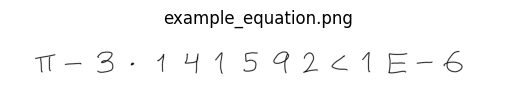

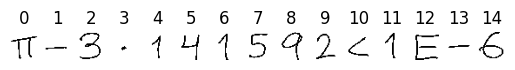

In [ ]:
imEv = ImageEvaluator('example_equation.png')
imEv.show_image();

imEv.extract_symbols(hw=32);
imEv.show_symbols();

##Experimentation and Evaluation

###Form plots/tables of CNN performance on train, val, and test data

We lifted the definition of CNN2D from assignment 5, and used our grid_search function on it.

In [ ]:
# Copied from assignment 5
class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)

        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append((loss_sum / num_batches).detach().cpu().numpy())

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

Just to make sure everything worked as expected before performing the grid search, we trained the network provided in assignment 5 on our dataset for 100 epochs, and generated a confusion matrix of the results.

In [ ]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

n_epochs = 100
batch_size = 500
learning_rate = 0.01
n_in = images.shape[2] * images.shape[3]
n_out = len(np.unique(labels))

cnet = CNN2D(n_in, n_hiddens_per_conv_layer,
             n_hiddens_per_fc_layer, n_out,
             patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 10 Loss 0.661
adam: Epoch 20 Loss 0.478
adam: Epoch 30 Loss 0.425
adam: Epoch 40 Loss 0.371
adam: Epoch 50 Loss 0.339
adam: Epoch 60 Loss 0.322
adam: Epoch 70 Loss 0.304
adam: Epoch 80 Loss 0.288
adam: Epoch 90 Loss 0.292
adam: Epoch 100 Loss 0.276


In [ ]:
# Copied from assignment 5, with added argument for class translation
def confusion_matrix(Y_classes, T, class_map):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_map[class_names], columns=class_map[class_names])
    return conf_matrix

def pretty(cm):
  return cm.style.background_gradient(axis=1).format("{:.2f}").set_properties(**{"font-size": "10px"})

In [ ]:
#This is an example of the results as described above
Classes, _ = cnet.use(Xtest)
perc_correct = np.mean(Classes == Ttest)
print(f'Test set accuracy: {perc_correct:.2f}')
pretty(confusion_matrix(Classes, Ttest, unicode_map))

Test set accuracy: 0.84


,0,1,2,3,4,5,6,7,8,9,·,π,e,i,≤,≥,<,>,≡,≠,-,+,×,/,%,*,&,|,~,[,],E
0,0.66,0.00,0.00,0.06,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.09,0.00
1,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00
2,0.00,0.00,0.39,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.17,0.00,0.00,0.00,0.00,0.00,0.17,0.00
3,0.00,0.00,0.12,0.46,0.00,0.04,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.27,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.09,0.09,0.00,0.09,0.00,0.00,0.00
5,0.06,0.00,0.06,0.06,0.00,0.19,0.00,0.00,0.06,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.19,0.00,0.00,0.00,0.00,0.25
6,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.19,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.06,0.00,0.00,0.00
7,0.00,0.00,0.50,0.07,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.04,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.12,0.00,0.42,0.00,0.00,0.00,0.00,0.04
9,0.11,0.00,0.06,0.11,0.00,0.00,0.00,0.00,0.00,0.28,0.00,0.06,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.11,0.00,0.00,0.00,0.00,0.00,0.11,0.00


The results were **Not** great, so we hoped we could find a better network architecture with the grid search. The hyperparameters we fixed for the grid search were the number of epochs, the activation function, the learning rate, the optimizer, and batch size. The hyperparameters left were then:

* Number of hidden units per convolutional layer
* Number of hidden units per fully connected layer
* Patch size per convolutional layer
* Stride length per convolutional layer

Most of the hyperparameter combinations we tried failed, as they resulted in invalid CNN architectures. As such, expected the grid search to completee in a reasonable amount of time.

It completed in about two hours.

In [ ]:
# DO NOT RE-RUN, takes ~2 hours
df = grid_search(Xtrain, Ttrain, CNN2D, n_folds=3, init_dict={
  'n_hiddens_per_conv_layer': hp_perms([10, 20], [2, 3]),
  'n_hiddens_per_fc_layer': hp_perms([5, 10], [1, 2]),
  'patch_size_per_conv_layer': hp_perms([5, 10], [2, 3]),
  'stride_per_conv_layer': hp_perms([2, 4], [2, 3]),
  'activation_function': ['relu']   # fixed
}, train_dict={
  'batch_size': [32],               # fixed
  'n_epochs': [10],                 # fixed
  'learning_rate': [0.001],         # fixed
  'method': ['adam']                # fixed
})

Hyperparameter combination 75/10368 (1)
3-fold cross validation: [======]
Hyperparameter combination 76/10368 (2)
3-fold cross validation: [======]
Hyperparameter combination 77/10368 (3)
3-fold cross validation: [======]
Hyperparameter combination 78/10368 (4)
3-fold cross validation: [======]
Hyperparameter combination 87/10368 (5)
3-fold cross validation: [======]
Hyperparameter combination 88/10368 (6)
3-fold cross validation: [======]
Hyperparameter combination 89/10368 (7)
3-fold cross validation: [======]
Hyperparameter combination 90/10368 (8)
3-fold cross validation: [======]
Hyperparameter combination 99/10368 (9)
3-fold cross validation: [======]
Hyperparameter combination 100/10368 (10)
3-fold cross validation: [======]
Hyperparameter combination 101/10368 (11)
3-fold cross validation: [======]
Hyperparameter combination 102/10368 (12)
3-fold cross validation: [======]
Hyperparameter combination 111/10368 (13)
3-fold cross validation: [======]
Hyperparameter combination 112

In [ ]:
# DO NOT RE-RUN, data is important
# Constant columns were dropped
df.drop(columns=['activation_function', 'batch_size', 'n_epochs', 'learning_rate', 'method']).nlargest(10, 'test acc')

,n_hiddens_per_conv_layer,n_hiddens_per_fc_layer,patch_size_per_conv_layer,stride_per_conv_layer,train acc,val acc,test acc
287,"(20, 20, 20)","(10,)","(5, 5, 5)","(2, 2, 4)",0.942668,0.900402,0.899550
191,"(20, 20, 20)","(10,)","(5, 5, 5)","(2, 2, 2)",0.948259,0.896585,0.897812
68,"(20, 20)","(10,)","(5, 5)","(2, 4)",0.942157,0.895221,0.895834
356,"(20, 20)","(10,)","(10, 10)","(2, 2)",0.956302,0.895699,0.895597
333,"(20, 10)","(10,)","(10, 5)","(2, 2)",0.932306,0.893381,0.894710
332,"(20, 20)","(10,)","(10, 5)","(2, 2)",0.937350,0.891949,0.894710
70,"(10, 20)","(10,)","(5, 5)","(2, 4)",0.933464,0.895733,0.893892
358,"(10, 20)","(10,)","(10, 10)","(2, 2)",0.950405,0.894131,0.893687
309,"(20, 10)","(10,)","(5, 5)","(2, 2)",0.930773,0.891301,0.892732
334,"(10, 20)","(10,)","(10, 5)","(2, 2)",0.934420,0.890756,0.892562


Now, we'll re-train the best architecture found, analyze it, and use it to evaluate an expression.

In [ ]:
# re-train best network architecture
n_inputs = images.shape[2] * images.shape[3]
n_outputs = len(np.unique(labels))
model = CNN2D(n_inputs=n_inputs, n_outputs=n_outputs, device=device,
              activation_function='relu',
              n_hiddens_per_conv_layer=[20, 20, 20],
              n_hiddens_per_fc_layer=[10],
              patch_size_per_conv_layer=[5, 5, 5],
              stride_per_conv_layer=[2, 2, 4])

model.train(Xtrain, Ttrain, 32, 50, 0.001, 'adam', verbose=True);

adam: Epoch 5 Loss 0.218
adam: Epoch 10 Loss 0.106
adam: Epoch 15 Loss 0.067
adam: Epoch 20 Loss 0.043
adam: Epoch 25 Loss 0.027
adam: Epoch 30 Loss 0.043
adam: Epoch 35 Loss 0.020
adam: Epoch 40 Loss 0.009
adam: Epoch 45 Loss 0.012
adam: Epoch 50 Loss 0.017


In [ ]:
# DO NOT RE-RUN, data is important
Classes, _ = model.use(Xtest)
perc_correct = np.mean(Classes == Ttest)
print(f'Best model test set accuracy: {perc_correct:.2f}')
pretty(confusion_matrix(Classes, Ttest, unicode_map))

Best model test set accuracy: 0.94


,0,1,2,3,4,5,6,7,8,9,·,π,e,i,≤,≥,<,>,≡,≠,-,+,×,/,%,*,&,|,~,[,],E
0,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00
2,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.06,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.06,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.88,0.00,0.04,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.55,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06
6,0.06,0.00,0.00,0.00,0.00,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.06,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.46,0.00,0.00,0.00,0.00,0.00
9,0.00,0.06,0.00,0.11,0.00,0.06,0.00,0.00,0.00,0.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00


###Display which examples the network performs the worst on

Using the code from A4, we decided to display which examples the network performs the worst on. This not only gives an example of what kind of symbols are contained in the HASYv2 data set, but also an explaination as to why the CNN might confuse one symbol for another.

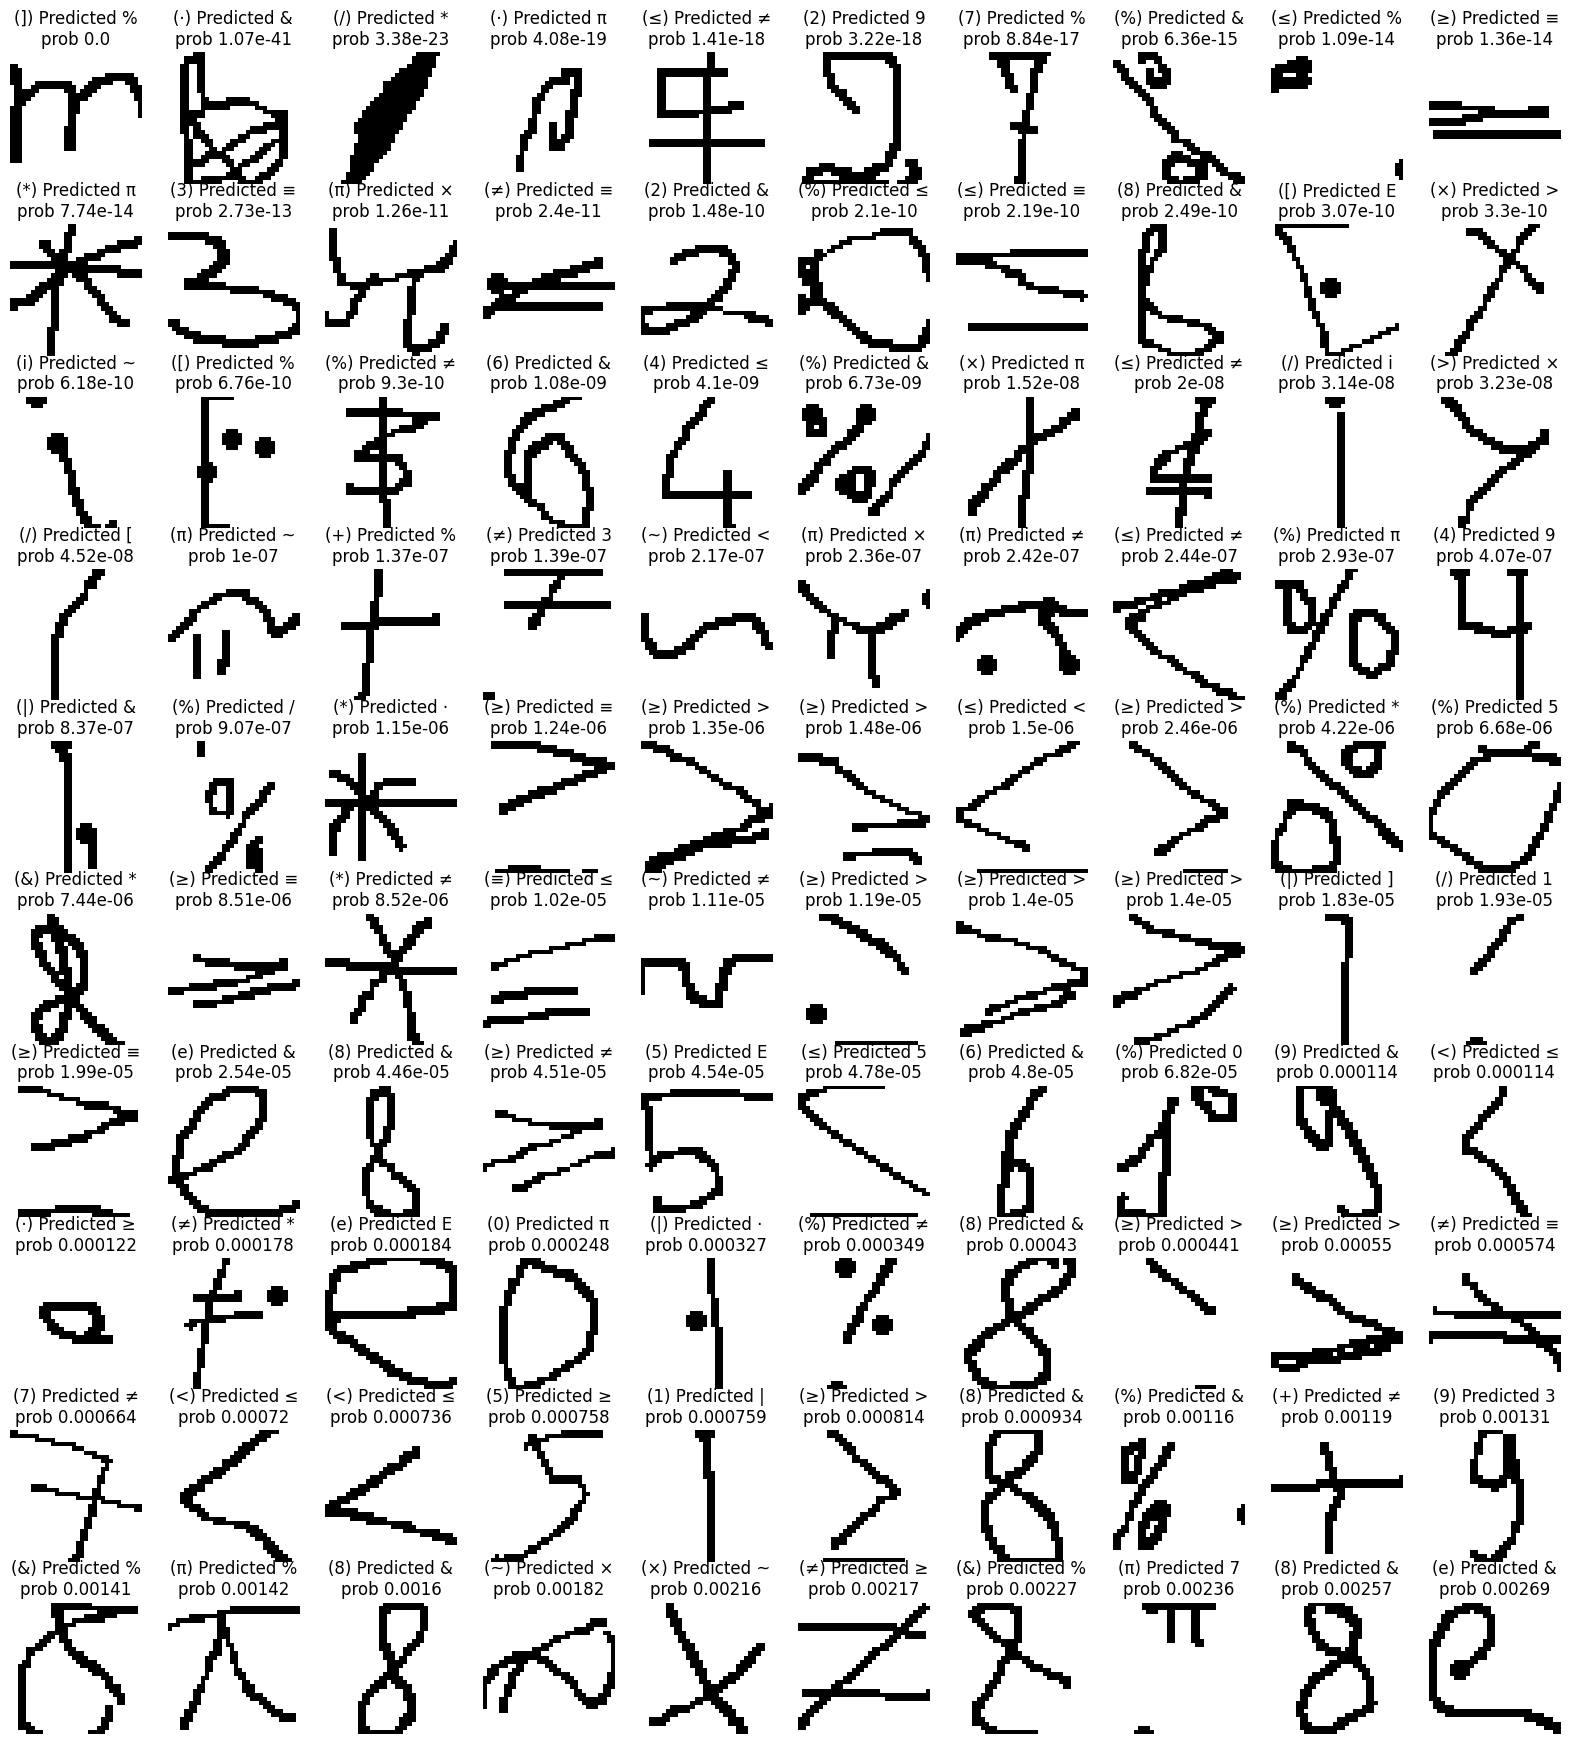

In [ ]:
#Copied from A4
Ytest, prob = model.use(Xtest)

classes = np.unique(Ttest)
worst_preds = np.argsort(prob[classes==Ttest])

plt.figure(figsize=(20, 22))
for i in range(100):
    w = worst_preds[i]
    truth = Ttest[w, 0]
    plt.subplot(10, 10, i + 1)
    plt.imshow(-Xtest[w, :].reshape(32, 32), cmap='gray')
    plt.title(f'({unicode_map[truth]}) Predicted {unicode_map[Ytest[w, 0]]}\nprob {prob[w, truth]:.3}')
    plt.axis('off');

As predicted, the CNN struggled to classify a varity of greater/less than symbols. Moreover, the data above shows most of the problematic examples are symbolic in nature. There are a few digits such as 2, 5, 6, and 8, but most of them are being mistaken for symbols, mostly "&" which is expected.

One explanation of this could be that digits in general are underrepresented in the subset of HASYv2 we chose. This idea is also supported by the confusion matrix above. As a whole, this shows the variety of the data set and the capabilities of the CNN with the chosen architecture.

###Use the CNN's classifications to construct and evaluate a python expression

Here, we apply the model trained above to the example equation from before:

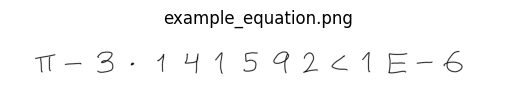

Predicted classes: π - 3 · 1 4 ~ 5 9 2 ≤ 1 ≠ - ≤
Constructed expression: math.pi-3.14not 592<=1!=-<=
Result: Evaluation failed


In [ ]:
#DO NOT RE-RUN
imEv = ImageEvaluator('example_equation.png')
imEv.show_image();

imEv.extract_symbols(hw=32);
# imEv.show_symbols();

classes, expression, result = imEv.evaluate_using(model, python_map)
print('Predicted classes:', classes)
print('Constructed expression:', expression)
print('Result:', result)

As we can see, the results are not great. We have two explanations for this:
1. The extracted symbols are not part of the dataset that the model was trained on, and so they are likely slightly different, causing reduced accuracy
2. Even with a test set accuracy of 95%, in classifying a 15-symbol expression, the chance of arriving at the correct answer is 46.33%

## Conclusions

Through utilization of the HASYv2 dataset and Assignments 3-5, we were able to use a CNN to classify and recognize the symbols in a math expression and evaluate its result with some success.

We first had to expriement with the CNN from A5. By testing a large variety of architectures, we were able to find the one with the highest accuracy value and use that to evaluate our expressions.

We were able to produce evidence of quality classifying accuracy through the usage of a confusion matrix, but also found that due to the quantity of classes and the length of some expressions we still had a low chance of producting an accurate evaluation.

Overall, we did what we set out to do:
1. We used the CNN and HASYv2 dataset and learned what symbols were the most difficult to identitfy.
2. We analyzed why those symbols were difficult to identify and used a variety of methods to combat those issues.
3. We solved a variety of math problems within the limitations provided by the CNN and chosen dataset.

This project allowed use to utilize skills and methods taught in this class to solve an interesting and applicable problem. Although we were unable to find a perfect answer to our question, we were able to experiement, struggle, and develop solutions to our limitations, thus allowing us to successfully evaluate hand-written mathematics problems using a CNN.



##References

[1] Thoma, M. (2017). The hasyv2 dataset. arXiv preprint arXiv:1701.08380. https://doi.org/10.48550/arXiv.1701.08380

[2] Assignment 3

[3] Assignment 5

[4] Assignment 4